In [1]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from  pandas_datareader import DataReader

from datetime import datetime

from __future__ import division

In [17]:
# My Data
tech_list = ['AAPL','GOOG','MSFT','AMZN']

end = datetime.now()
start = datetime(end.year - 1,end.month,end.day)

for stock in tech_list:
    globals()[stock]=DataReader(stock, 'yahoo', start, end)

closing_df = DataReader(['AAPL','GOOG','MSFT','AMZN'],'yahoo',start,end)['Adj Close']
tech_rets = closing_df.pct_change()
AAPL['Daily Return'] = AAPL['Adj Close'].pct_change()

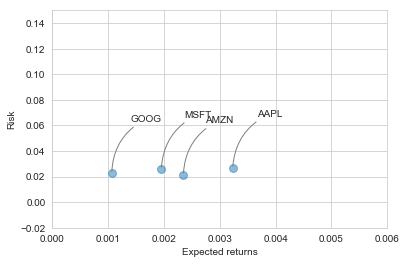

In [18]:
# To quantify risk, one way is by comparing the expected return with the standard deviation of the daily returns.

# The DataFrame (clenaed version of the oriignal tech_rets DataFrame)
rets = tech_rets.dropna()
area = np.pi*20
plt.scatter(rets.mean(), rets.std(),alpha = 0.5,s =area)

# Set the x and y limits of the plot
plt.ylim([-0.020,0.150])
plt.xlim([0.000,0.006])

# Label
plt.xlabel('Expected returns')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (50, 50),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3, rad=0.3',color="0.5",))

In [29]:
# Value at Risk
# Def.: We can treat value at risk as the amount of money we could expect to lose (aka putting at risk) for a given confidence interval. 

# Value at risk: Apple (using the "bootstrap" method)
rets['AAPL'].quantile(0.05)

-0.037732801073493395

In [30]:
# The 0.05 empirical quantile of daily returns is at -0.019. That means that with 95% confidence, our worst daily loss will not exceed 1.9%. If we have a 1 million dollar investment, our one-day 5% VaR is 0.019 * 1,000,000 = $19,000.

In [31]:
# Value at risk: Amazon

rets['AMZN'].quantile(0.05)

-0.029078963947030634

In [32]:
# Value at risk: Google
rets['GOOG'].quantile(0.05)

-0.03653258472867073

In [33]:
 # Value at risk: Microsoft
 rets['MSFT'].quantile(0.05)

-0.03643093718794933

In [34]:
# Monte Carlo method

# Definition of the variables for the Google DataFrame GOOG
days = 365
dt = 1/days
mu = rets.mean()['GOOG']
sigma = rets.std()['GOOG']

In [35]:
# Creation of the function (it takes in the starting price and number of days, and uses the sigma and mu)
def stock_monte_carlo(start_price,days,mu,sigma):
    
    # Define a price array
    price = np.zeros(days)
    price[0] = start_price
    # Schok and Drift
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    # Run price array for number of days
    for x in xrange(1,days):
        
        # Calculate Schock
        shock[x] = np.random.normal(loc=mu * dt, scale=sigma * np.sqrt(dt))
        # Calculate Drift
        drift[x] = mu * dt
        # Calculate Price
        price[x] = price[x-1] + (price[x-1] * (drift[x] + shock[x]))
        
    return price

In [37]:
GOOG.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-01,1234.109985,1205.719971,1214.030029,1209.010010,1698500,1209.010010
2019-08-02,1206.900024,1188.939941,1200.739990,1193.989990,1645100,1193.989990
2019-08-05,1175.239990,1140.140015,1170.040039,1152.319946,2597500,1152.319946
2019-08-06,1179.959961,1160.000000,1163.310059,1169.949951,1709400,1169.949951
2019-08-07,1178.444946,1149.624023,1156.000000,1173.989990,1444300,1173.989990


Text(0.5,1,'Monte Carlo Analysis for Google')

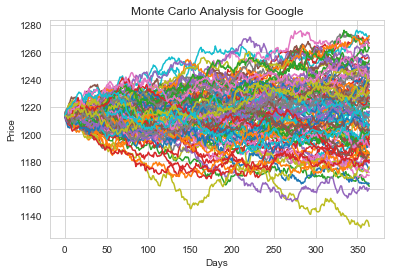

In [38]:
start_price = 1214.03

# Run simultation 100 times
for run in range(100):
    plt.plot(stock_monte_carlo(start_price,days,mu,sigma))
plt.xlabel("Days")
plt.ylabel("Price")  
plt.title('Monte Carlo Analysis for Google')

In [41]:
# Create a histogram of the end results for a much larger run (only the end points)

runs = 10000

# Create an empty matrix to hold the end price data
simulations = np.zeros(runs)

# Set the print options of numpy to only display 0-5 points from an array to suppress output
np.set_printoptions(threshold=5)

for run in xrange(runs):    
    # Set the simulation data point as the last stock price for that run
    simulations[run] = stock_monte_carlo(start_price,days,mu,sigma)[days-1]

Text(0.5,1,u'Final price distribution for Google Stock after 365 days')

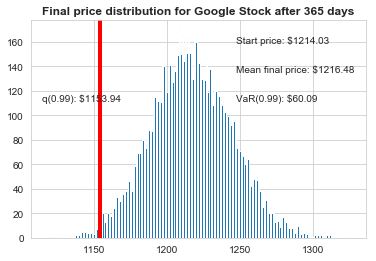

In [42]:
# Create the histogram
# Define q as the 1% empirical qunatile
q = np.percentile(simulations, 1)
    
# Now let's plot the distribution of the end prices
plt.hist(simulations,bins=200)

# Using plt.figtext to fill in some additional information onto the plot

# Starting Price
plt.figtext(0.6, 0.8, s="Start price: $%.2f" %start_price)
# Mean ending price
plt.figtext(0.6, 0.7, "Mean final price: $%.2f" % simulations.mean())

# Variance of the price (within 99% confidence interval)
plt.figtext(0.6, 0.6, "VaR(0.99): $%.2f" % (start_price - q,))

# Display 1% quantile
plt.figtext(0.15, 0.6, "q(0.99): $%.2f" % q)

# Plot a line at the 1% quantile result
plt.axvline(x=q, linewidth=4, color='r')

# Title
plt.title(u"Final price distribution for Google Stock after %s days" % days, weight='bold')